In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import MESS
import numpy as np
import pandas as pd

from IPython.display import display

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Load and curate the snail pi and trait data
Takes a little bit of work since there are some mismatches between naming schemes and some samples in one set and not in the other, but eventually we get there.

,pi,trait
AL_N_sp1,0.008677,-0.754505
WF_N_elaeodes,0.010133,0.069074


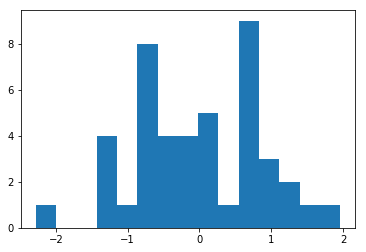

In [75]:
sn_dir = "/home/isaac/SGD_empirical/empirical_snails/"
sn_pis = pd.read_csv(sn_dir + "snail.pis", sep=",", header=0, index_col=0)
sn_pis.columns = ['pi']

## Insert the "_N_" in the species name for all species for agreement with
## names in the trait table
sn_pis.index = [x.replace("_", "_N_") for x in sn_pis.index]

sn_traits = pd.read_csv(sn_dir + "Naesiotus_Shell_measurements.csv", sep=",", index_col=0, header=0)
## Convert width and height to volume of a cone (roughly) 1/3*pi*r^2*h
sn_traits["ShellVolume"] = (np.pi * (sn_traits["ShellWidth"]/2)**2 * sn_traits["ShellHeight"])/3

## Fix names that don't agree between pis and traits
sn_traits.rename(index={'PI_N_nov_sp':'PI_N_nov'},inplace=True)
sn_traits.rename(index={'SC_N_cf_reibischi':'SC_N_reibischi'},inplace=True)
sn_traits.rename(index={'FA_N_perrus_sp1':'FA_N_perrus'},inplace=True)

## Finally drop a couple species that are in one and not the other
sn_pis = sn_pis.drop("PI_N_pinzonopsis")
sn_traits = sn_traits.drop(['PI_N_pinzonensis', 'FA_N_perrus_sp2'])

## And drop a duplicate species name from the trait index "SC_N_reibischi"
sn_traits = sn_traits[sn_traits["ID on Phylo"] != 'SC_N_cf_reibischi_SC14_141_5']

## Join pi and trait DFs
sn_df = pd.concat([sn_pis, sn_traits], axis=1, sort=False)
sn_df = sn_df.drop(["ID on Phylo", "ShellHeight", "ShellWidth"], axis=1)

## Log and zero center ShellVolume and rename the column as 'trait'
sn_df["ShellVolume"] = np.log(sn_df["ShellVolume"])
sn_df["ShellVolume"] = sn_df["ShellVolume"] - np.mean(sn_df["ShellVolume"])
sn_df.columns = ["pi", "trait"]

## Verify roughly normally distributed
plt.hist(sn_df["trait"], bins=15)

## Write to file to save
sn_df.to_csv(sn_dir + "snail_df.csv")
display(sn_df[:2])

## Split the full data to dataframes per island
We will split samples to 3 islands which have the most samples/species: Isabela (0.3-0.6My), San Cristobal (3.2My), and Santa Cruz (1.8My):

    CA: Cerro Azul volcano on Isabela
    SN: Sierra Negra volcano on Isabela
    DA: Darwin volcano on Isabela
    AL: Alcedo volcano on Isabela
    WF: Wolf volcano on Isabela

    SL: San Cristobal

    SC: Santa Cruz


In [96]:
sl_species = [x for x in sn_df.index if "SL" in x]
sc_species = [x for x in sn_df.index if "SC" in x]
is_species = [x for x in sn_df.index if x.split("_")[0] in ["CA", "SN", "DA", "AL", "WF"]]
sl_df = sn_df.loc[sl_species, :]
sc_df = sn_df.loc[sc_species, :]
is_df = sn_df.loc[is_species, :]
print("N species - ")
for n, df in zip(["San Cristobal", "Santa Cruz", "Isabela"],\
                [sl_df, sc_df, is_df]):
    print("\t{}  \t{}".format(n, len(df)))


N species - 
	San Cristobal  	7
	Santa Cruz  	11
	Isabela  	10


## Estimate parameters combining all data at the archipelago scale

In [97]:
simfile = "/home/isaac/Continuosity/MESS/analysis/full-parameter-estimation/SIMOUT_small_speciation.txt"

rgr = MESS.inference.Regressor(empirical_df=sn_df, simfile=simfile, algorithm="rf")
rgr.predict(select_features=False, quick=True, verbose=True)

Finding best model parameters.
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   11.9s remaining:   47.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   22.5s finished


{'n_estimators': 400, 'min_samples_split': 10, 'bootstrap': True, 'max_depth': 70, 'min_samples_leaf': 4}
         alpha           J_m  ecological_strength         m  speciation_prob   _lambda
0  3752.193178  2.753060e+06             5.993041  0.007367         0.000606  0.774739


## Estimate parameters for each of the 3 most speciose islands

In [99]:
for n, df in zip(["San Cristobal", "Santa Cruz", "Isabela"],\
                [sl_df, sc_df, is_df]):
    print("Estimate params for {}".format(n))
    rgr = MESS.inference.Regressor(empirical_df=df, simfile=simfile, algorithm="rf")
    rgr.predict(select_features=True, quick=False, verbose=True)

Estimate params for San Cristobal
Selecting features:
  alpha	['S', 'pi_h1', 'pi_h2', 'pi_h3', 'mean_pi', 'std_pi', 'skewness_pi', 'kurtosis_pi', 'median_pi', 'iqr_pi', 'SGD_0']
  J_m	['S', 'SGD_0']
  ecological_strength	[]
  m	['S', 'mean_pi', 'std_pi', 'SGD_0', 'SGD_5']
  speciation_prob	[]
  _lambda	['S', 'pi_h1', 'pi_h2', 'pi_h3', 'pi_h4', 'mean_pi', 'std_pi', 'kurtosis_pi', 'SGD_0']
All selected features: S pi_h1 pi_h2 pi_h3 pi_h4 mean_pi std_pi skewness_pi kurtosis_pi median_pi iqr_pi SGD_0 SGD_5
Finding best model parameters.
Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 98.6min finished


{'n_estimators': 1600, 'min_samples_split': 10, 'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2}
         alpha           J_m  ecological_strength         m  speciation_prob   _lambda
0  3547.472862  2.924522e+06             5.976448  0.002184         0.000331  0.633052
Estimate params for Santa Cruz
Selecting features:
  alpha	['S', 'pi_h1', 'pi_h2', 'pi_h3', 'mean_pi', 'std_pi', 'skewness_pi', 'kurtosis_pi', 'median_pi', 'iqr_pi', 'SGD_0']
  J_m	['S', 'SGD_0']
  ecological_strength	[]
  m	['S', 'mean_pi', 'std_pi', 'SGD_0', 'SGD_5']
  speciation_prob	[]
  _lambda	['S', 'pi_h1', 'pi_h2', 'pi_h3', 'pi_h4', 'mean_pi', 'std_pi', 'kurtosis_pi', 'SGD_0']
All selected features: S pi_h1 pi_h2 pi_h3 pi_h4 mean_pi std_pi skewness_pi kurtosis_pi median_pi iqr_pi SGD_0 SGD_5
Finding best model parameters.
Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 50.0min finished


{'n_estimators': 2000, 'min_samples_split': 2, 'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1}
         alpha           J_m  ecological_strength         m  speciation_prob   _lambda
0  3873.955585  2.531299e+06             6.243766  0.002489          0.00032  0.721951
Estimate params for Isabela
Selecting features:
  alpha	['S', 'pi_h1', 'pi_h2', 'pi_h3', 'mean_pi', 'std_pi', 'skewness_pi', 'kurtosis_pi', 'median_pi', 'iqr_pi', 'SGD_0']
  J_m	['S', 'SGD_0']
  ecological_strength	[]
  m	['S', 'mean_pi', 'std_pi', 'SGD_0', 'SGD_5']
  speciation_prob	[]
  _lambda	['S', 'pi_h1', 'pi_h2', 'pi_h3', 'pi_h4', 'mean_pi', 'std_pi', 'kurtosis_pi', 'SGD_0']
All selected features: S pi_h1 pi_h2 pi_h3 pi_h4 mean_pi std_pi skewness_pi kurtosis_pi median_pi iqr_pi SGD_0 SGD_5
Finding best model parameters.
Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 50.6min finished


{'n_estimators': 800, 'min_samples_split': 2, 'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2}
         alpha           J_m  ecological_strength         m  speciation_prob   _lambda
0  3795.216974  2.602775e+06             5.904545  0.002972         0.000334  0.736289
